### Example notebook - differential gene expression for different cancer types

This notebook demonstrates reading from API and performing analysis of differential gene expression.
- title: "DGE - Cancer Types"
- author: "Margaret Paiva"
- date: "21/10/2021"
- output: R notebook

In [9]:
# cran packages
x <- c('jsonlite',
       'rjson',
       'httr',   
       'dplyr', 
       'data.table', 
       'parallel', 
       'DBI', 
       'DT', 
       'tidyr', 
       'tibble', 
       'ggplot2')
# bioconductor packages
y <- c('limma', 
       'fgsea')

In [10]:
# install cran packages
for (pkg in x) {
    if (!pkg %in% rownames(installed.packages())) {install.packages(pkg)}
}

In [11]:
# install bioconductor packages
if (!requireNamespace("BiocManager", quietly=TRUE))
    install.packages("BiocManager")
for (pkg in y) {
    if (!requireNamespace(pkg, quietly=TRUE)) {
        BiocManager::install(pkg)
    }
}

In [12]:
# load packages
load_lib <- function(x) {
    suppressPackageStartupMessages(library(x, character.only = TRUE))
}
invisible(lapply(c(x, y), load_lib))

Request data from API if it is not done yet.

In [3]:
# In "gene_list.csv", define a list of genes of interest
gene_list  <- as.list(read.csv("gene_list.csv")$x)

In [34]:
# Define the data to query from API
data  <- list("request_data_type" = "expression",
  "request_cancer_type" = c("Renal cell carcinoma", "Prostate", "Adenoid cystic carcinoma", "Breast", 
                            "Thyroid", "Testicular", "Hepatocellular carcinoma", "Melanoma"),
#   "request_genes" = c("ATM", "BRCA1", "BRCA2", "BRIP1", "CDK12", "FANCA", "HDAC2", "KRAS", 
#                       "PALB2", "SRY", "TP53", "NOTCH1", "CCND1", "BARD1", "FBLN2", "CDKN1B", 
#                       "RB1", "CHEK2", "APOBEC3B", "PALB2"),  # to define a list of genes here
  "request_genes" = gene_list,  # if a list of genes is defined in a file
  "request_dataset" = "PDX",
  "request_key" = "---",  # enter your token here
  "request_client" = 99,
  "request_user" = 1234,  # enter your user id here
  "request_workspace_id" = "1234-99",  # enter your user id "XXXX-99"
  "request_mode" = 'true') 

In [35]:
# Request data from API - this may take some time
request  <-  POST(url = 'https://lumin-fast-api.championsoncology.com/WS', 
                  body = data, encode = 'json')
request
# A successful request will give "Status: 200"

Response [https://lumin-fast-api.championsoncology.com/workstation]
  Date: 2021-10-19 20:52
  Status: 200
  Content-Type: application/json
  Size: 75 B


In [36]:
# This will save the data file as a .json file in your root directory
response <- content(request)
response

[1] "success, the file you may view your requested data in your root directory"

In [4]:
# Enter the file name of the .json file in your root directory below
lt  <-  fromJSON(file = "./data/requested_data---19-10-2021---20_44_20.json")

In [5]:
# Create a dataframe from the data
df  <- do.call(rbind, lapply(lt, rbind))
df  <- as.data.frame(df)
df$tumor_type  <- as.character(df$tumor_type)  # each column is a list - specify data type
df$z  <- as.numeric(df$z)
head(df, 2)
print(dim(df))

v1,gene_id,log.rsem.rpkm,log.tpm,z,fold,trans,model,sort_key,gene,model_name,tumor_type
19463231,ENSG00000005187,2.03154538924124,2.74114899170484,-0.1693172,0.876569685689051,ENST00000440284:49.26% ENST00000567387:17.78% ENST00000501740:11.52% ENST00000289416:10.09%,CTG-3501,CTG-3501_Expression_1,ACSM3,CTG-3501,Breast
19463234,ENSG00000005243,0.43494348437293,0.799599647207579,-0.9946150,0.185174375597962,ENST00000006101:78.76% ENST00000579263:20.8%,CTG-3501,CTG-3501_Expression_1,COPZ2,CTG-3501,Breast


[1] 82800    12


In [6]:
# Define a gene of interest
gene_choice <- 'ACSM3'
df_gene  <- df %>% 
    na.omit()  %>% 
    filter(gene==gene_choice)  # put your gene of interest here
head(df_gene, 2)

v1,gene_id,log.rsem.rpkm,log.tpm,z,fold,trans,model,sort_key,gene,model_name,tumor_type
19463231,ENSG00000005187,2.03154538924124,2.74114899170484,-0.1693172,0.876569685689051,ENST00000440284:49.26% ENST00000567387:17.78% ENST00000501740:11.52% ENST00000289416:10.09%,CTG-3501,CTG-3501_Expression_1,ACSM3,CTG-3501,Breast
3972525,ENSG00000005187,2.56137935631413,3.21443031762327,0.1442849,1.1051820496776,ENST00000440284:35.32% ENST00000567387:22.97% ENST00000289416:15.38%,CTG-0718,CTG-0718_Expression_1,ACSM3,CTG-0718,Melanoma


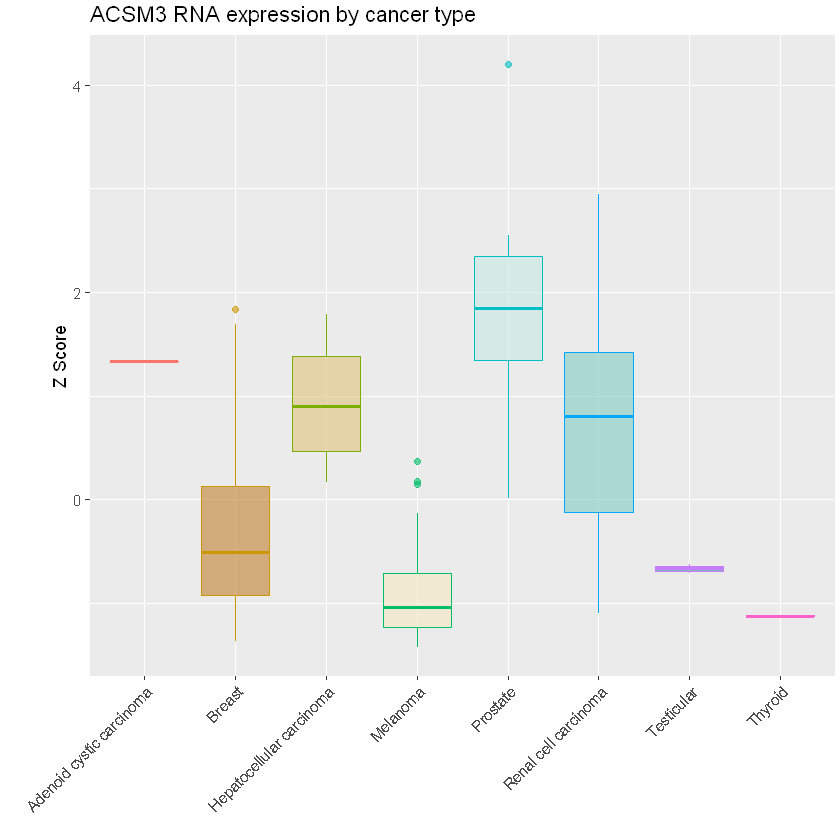

In [9]:
# Visualize the expression levels by cancer type
ggplot(df_gene, aes(x=tumor_type, y=z, fill=tumor_type, color=tumor_type)) +
    geom_boxplot(alpha=0.6) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "none", 
          plot.margin = unit(c(0,0,0,1)+0.1, "cm")) +
    labs(x="", y="Z Score", 
         title=paste0(gene_choice, " RNA expression by cancer type")) +
    scale_fill_brewer(palette="BrBG")